# Задача
одна из проблем, которую мы видим при обращении в саппорт - в разрезе разных категорий обращения необходимо смотреть в разные сервисы и собирать дополнительную информацию. На это уходит много времени. на одно обращение уходит в среднем 2 минуты поиска дополнительной информации. Стоимость часа работы сотрудника 6$.

Давайте поможем и оптимизируем время и деньги компании - сделаем модель,которая в зависимости от текста будет определять категорию обращения автоматически.

Тогда мы сможем сразу подготавливать информацию для наших операторов в течение 5 секунд (сбор и передача на фронт)

Нужно сделать модель многоклассовой классификации определения категории обращения

In [1]:

from sklearn.feature_extraction.text import TfidfVectorizer

import datetime
import requests
import collections as co
import string
import re

import nltk
from sumy.utils import get_stop_words as gsw1
from stop_words import safe_get_stop_words as gsw2


import pandas as pd
import numpy as np
import pickle

In [2]:

from io import StringIO

import matplotlib.pyplot as plt
import seaborn as sns


RANDOM_STATE = 42

from helpers import *
from preprocessor import Preprocessor
from libherokuserver import *

%matplotlib inline

In [2]:
def load_init(frac=1):
    """Load file
    frac: float, 0..1, sample fraction of used data
    """
    return pd.read_csv('./data/3categories_50.csv').sample(frac=frac, random_state=RANDOM_STATE)

In [4]:
def clear_message(message):
    """Clear message from garbage
    message: string
    """
    if type(message) != type(''):
        return ''
    message = re.sub('\[.*\]', '', message)
    message = re.sub("[!':']", '', message)
    message = re.sub("[^A-Za-z0-9,!.\/'+-=]", ' ', message)
    message = re.sub("\s+", ' ', message)
    message = message.lower()
    return message

In [5]:
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer


def get_sw(languages):
    """Create stop words list
    languages: list of strings, ex. ["english", "russian"]"""
    stopWords = nltk.corpus.stopwords.words()

    sw = {"yeah","zola","don", 'chat', 'transcript'}  | set(stopWords)
    for lang in languages:
        try: 
            sw |= gsw1(lang) | set(gsw2(lang))
        except:
            pass
    return sw


def get_baser(base='lem'):
    """Choose method of word basing
    base: string, 'lem' or 'stem'
    """
    if base == 'stem':
        stemming = PorterStemmer()
        basing_func = stemming.stem
    elif base == 'lem':
        lemmatizer = WordNetLemmatizer()
        basing_func = lemmatizer.lemmatize
    
    return basing_func


def basing(message, baser, stop_words=None):
    """Base each word in message and tagged them
    message: string
    baser: nltk.stem.porter.PorterStemmer or nltk.stem.WordNetLemmatizer
    stop_words: set() or list() of string, collection of words to delete from message
    """
    def get_words(sent):
        res = []
        for word in sent.split(): 
            checked = re.search('(\w+)',word)
            if checked:
                res.append(checked.group(0))
        return res
    
    words = get_words(message)
    words_tags = nltk.pos_tag(words)

    def check_word(word, tag):
        not_sw = word not in stop_words 
        not_digits = not re.match('\d+',word)
        nice_tag = tag in ['NN','VB','DT','NNS','VBP','VB']
        return not_sw and not_digits and nice_tag

    clear_words_tags = [word_tag for word_tag in words_tags if check_word(*word_tag)]

    clear_words = [word_tag[0] for word_tag in clear_words_tags]
    based_words = [baser(word) for word in clear_words]
    
    return based_words


def get_top_words(words_list_series, top_N=1500):
    """Select top N words by total count 
    words_list_series: pd.Series of string, based words of message
    top_N: int
    """
    c_text = co.Counter(
        np.concatenate(words_list_series.tolist(), axis=0 ))

    final_words = pd.DataFrame.from_dict(dict(c_text) , orient = 'index').sort_values(by = 0 , ascending = False).head(top_N).index.values    
    return final_words

In [6]:
def get_vectorized(based_words, y_target, top_words_count=1000):
    """Vectorize based words of message
    based_words: list of string
    y_target: pd.Series, targets, copy from original dataframe
    top_words_count: int
    """
    vec = TfidfVectorizer(max_features=top_words_count)
    
    tfidf_mat = vec.fit_transform(based_words).toarray()
    train = pd.DataFrame(tfidf_mat)

    train_columns = train.columns

    target = y_target.name
    train[target] =  y_target

    train.dropna(inplace=True)
    return train, train_columns, target, vec

In [ ]:
import datetime 
import os
import platform


class Notifier:
    """ Simple OS notifier to copy-paste-use 
    Example:
        notifier = Notifier()
        notifier.msg("Hello", title='Notifier')
    """
    def __init__(self):
        self.os = platform.system()
        
    def msg(self, message, title='Notifier'):
        """Send message to OS"""
        message = message.replace('\'', ' ').replace('\"', ' ')
        if self.os == 'Linux':
            os.system(f"notify-send \"{title}\" '{message}'")
        elif self.os == 'Darwin':
            os.system(f"osascript -e \'display notification \"{message}\" with title \"{title}\"\'")
        else:
            # TODO: win notification
            pass


class Clock:
    """Simple clock to copy-paste-use
    Example:
        >>> clock = Clock("Request")
        >>> data = requests.get('http://facebuk.com/users/all/secret/100TB/download')
        >>> clock.tik("Loaded! ")
        [  Request  ]Loaded!    123456.789 s
        >>>
    """
    def __init__(self, label, notify_os=False):
        self.label = label
        self.start = datetime.datetime.now()
        self.notifier = Notifier() if notify_os else None
    
    def reset(self):
        """Reset time"""
        self.start = datetime.datetime.now()
        
    def tik(self, output='', show_time=False):
        """Reset time and output"""
        now = datetime.datetime.now()
        self.start, delta = now, now - self.start
        message = f"[{self.label:^10}] {output:15}" 
        if show_time:
            message += f"{delta.total_seconds():12.2f} s"
            
        print(message)
        if self.notifier:
            self.notifier.msg(message, title="Python Clock")
        

if __name__ == "__main__":
    clock = Clock('Test')
    for i in range(10000000):
        pass
    clock.tik('test run', show_time=True)

In [7]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler


class Preprocessor:
    """Class created to be able to pickle"""
    def __init__(self, frac=0.03, word_base='lem', top_words_count=1000, test_total_ratio=0.2):
        self.frac=frac
        self.word_base=word_base
        self.top_words_count=top_words_count
        self.test_total_ratio=test_total_ratio
        
    def run(self):
        """Run preprocessing"""
        
        clock = Clock(f'Preproc {self.frac:4}', notify_os=True)
        
        # load & clean data
        df = load_init(frac=self.frac)
        df['category'], labels = pd.factorize(df['category'])
        self.label_map = {v: i for i, v in list(enumerate(labels))}
        df['message'] = df['message'].apply(clear_message)


        clock.tik(f'Basing... ({self.word_base})')
        self.stop_set = get_sw([
            'english',
            'russian',
            'chinees'
        ])
        self.baser = get_baser('lem')
    
    
        # base message words
        df['based_words'] = df['message'].apply(lambda x: basing(x, self.baser, self.stop_set))
        self.top_words = get_top_words(df['based_words'], top_N=self.top_words_count)
        
        
        # filter words
        filter_words = lambda words: [word for word in words if word in self.top_words]
        df['filtered_words'] = df['based_words'].apply(filter_words)

        clock.tik('Basing done', show_time=True)
        
        
        # vectorize
        vec_result = get_vectorized(df['filtered_words'].apply(lambda x: ' '.join(x)), 
                                    df['category'], 
                                    top_words_count=self.top_words_count)
        train, train_columns, target, self.vectorizer = vec_result

        
        # oversample
        clock.tik('Oversampling...')
        ros = RandomOverSampler()
        X_ros, y_ros = ros.fit_sample(train[train_columns], train[target])
        clock.tik('Oversampling done!', show_time=True)
        X_ros[target] = y_ros
        train = X_ros[:]

        
        # split on train and test
        x_train, x_test, y_train, y_test = train_test_split( train[train_columns]
                                                           , train[target] 
                                                           , test_size=self.test_total_ratio
                                                           , random_state=RANDOM_STATE 
                                                           , stratify = train[target] 
                                                           )
        clock.tik(f" Train: {train.shape}")
        return x_train, x_test, y_train, y_test
    

    def message_prepare(self, message):
        """Vectorize message"""
        based = basing(message, self.baser, self.stop_set)
        
        filter_words = lambda words: [word for word in words if word in self.top_words]
        filtered = filter_words(based)
        
        vectorized =  self.vectorizer.transform([' '.join(filtered)]).toarray()
        return vectorized

In [3]:
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import classification_report

from mlxtend.evaluate import  confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

def pretty_output(predicted_labels, true_labels):
    """Notebook beautiful output :3 """
    cm = confusion_matrix(y_target=true_labels, 
                          y_predicted=predicted_labels)

    fig, ax = plot_confusion_matrix(conf_mat=cm)

    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    print(classification_report(true_labels, predicted_labels))
    plt.show()

In [4]:
## Here preprocessing occurs 
params = {
    "word_base": 'lem',
    "top_words_count": 1500,
    "test_total_ratio": 0.3,
}

## --- To easy debug switch ----
# FLAG_DEBUG_FULL = True
FLAG_DEBUG_FULL = False
## -----------------------------

frac = 1 if FLAG_DEBUG_FULL else 0.8

preproc = Preprocessor(frac=frac, **params)
preproc_result = preproc.run()


x_train, x_test, y_train, y_test = preproc_result

[Preproc  0.8] Basing... (lem)
[Preproc  0.8] Basing done          399.72 s
[Preproc  0.8] Oversampling...
[Preproc  0.8] Oversampling done!       12.84 s
[Preproc  0.8]  Train: (67485, 1501)


In [210]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

## --- To easy debug switch ----
LOAD_DUMPS = False
# LOAD_DUMPS = True
## -----------------------------

if LOAD_DUMPS:
    model = pickle.load(open("final_model.pickle", "rb"))
    preproc = pickle.load(open("final_preproc.pickle", "rb"))
else:
    # best model I can made now
    clf = RandomForestClassifier(n_estimators=20,
                                 max_depth=600,
                                 max_features=3,
                                 n_jobs=-1,
#                                  class_weight="balanced",
                                 random_state=RANDOM_STATE)

    clock = Clock('RFC')

    X_TRAIN = x_train
    Y_TRAIN = y_train

    X_TEST = x_test
    Y_TEST = y_test

    model = clf.fit(X_TRAIN, Y_TRAIN)
    clock.tik(f' Finnished: ', show_time=True)
    
    
def class_predict(message, preproc, model):
    """Make prediction of message with ordering
    message: string
    preproc: Preprocessor
    model: ML model with predict_proba func
    """
    _order=['afs', 'other', 'ps']
    vec = preproc.message_prepare(message)
    pred = model.predict_proba(vec)[0]    
    
    results = dict(enumerate(pred))  
    return [results[preproc.label_map[_class]] for _class in _order]

class_predict("Hello, payment... Thanks", preproc, model)

[   RFC    ]  Finnished:            4.70 s


[0.7540103536973132, 0.13746332738296813, 0.10852631891971867]

In [211]:
## --- To easy debug switch ----
pickle.dump(model, open("final_model.pickle", "wb"))
pickle.dump(preproc, open("final_preproc.pickle", "wb"))
## -----------------------------

              precision    recall  f1-score   support

         0.0       0.87      0.82      0.84      6748
         1.0       0.85      0.95      0.90      6749
         2.0       0.91      0.87      0.89      6749

    accuracy                           0.88     20246
   macro avg       0.88      0.88      0.88     20246
weighted avg       0.88      0.88      0.88     20246



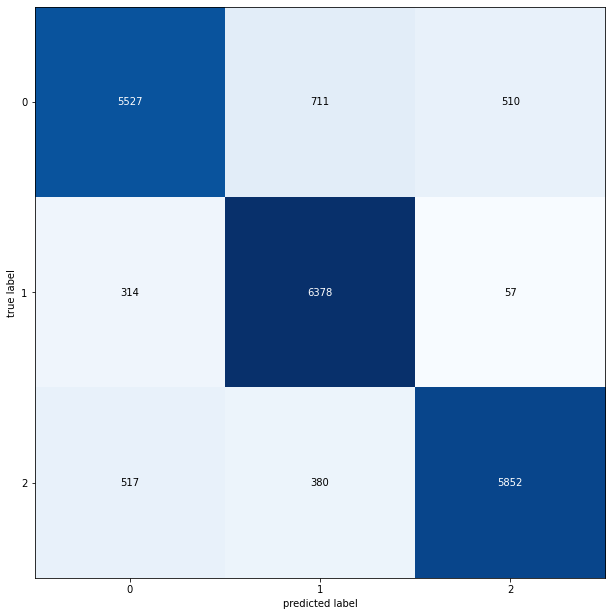

In [7]:
pretty_output(model.predict(X_TEST), Y_TEST)

In [8]:
raise Exception("STOP")
# Further cells are out of main thread, so stop execution with Exeption

Exception: STOP

In [ ]:
## Addintion - Model selection

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA


history = []

models = {
    "mlp": MLPClassifier(hidden_layer_sizes = (5, 7), 
                         solver='lbfgs',
                         learning_rate_init=0.0001,
                         max_iter = 10000, 
                         random_state = RANDOM_STATE),
    "rfc": RandomForestClassifier(n_estimators=100,
                                  max_depth=100,
                                  n_jobs=-1,
                                 random_state=RANDOM_STATE)
}

for i in range(1, 45):
    clf = RandomForestClassifier(n_estimators=399,
                                 max_depth=70,
                                 max_features=27,
                                 n_jobs=-1,
                                 class_weight="balanced",
                                 random_state=RANDOM_STATE)
    clock = Clock('MLP')
    
    model = clf.fit(x_train_full, y_train_full)
    history.append(model.score(x_test, y_test))
    clock.tik(f'Run: {i:2}, Accuracy: {history[-1]:.3}', show_time=True)

plt.plot(history)

In [ ]:
pretty_output(model.predict(X_TEST), Y_TEST)

In [ ]:
import pickle

#кешируем
# pickle.dump(x_train_full, open("m_x_train_1500_full.pickle", "wb"))
# pickle.dump(y_train_full, open("m_y_train_1500_full.pickle", "wb"))
# pickle.dump(x_test_full, open("m_x_test_1500_full.pickle", "wb"))
# pickle.dump(y_test_full, open("m_y_test_1500_full.pickle", "wb"))

x_train_full = pickle.load(open("m_x_train_1500_lem_full.pickle", "rb"))
y_train_full = pickle.load(open("m_y_train_1500_lem_full.pickle", "rb"))
x_test_full = pickle.load(open("m_x_test_1500_lem_full.pickle", "rb"))
y_test_full = pickle.load(open("m_y_test_1500_lem_full.pickle", "rb"))


In [9]:
import joblib

In [10]:
joblib.dump(model, '_test.jlib.pack')

['_test.jlib.pack']

In [207]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

## --- To easy debug switch ----
LOAD_DUMPS = False
# LOAD_DUMPS = True
## -----------------------------

if LOAD_DUMPS:
    model = pickle.load(open("final_model.pickle", "rb"))
    preproc = pickle.load(open("final_preproc.pickle", "rb"))
else:
    # best model I can made now
    clf = RandomForestClassifier(n_estimators=20,
                                 max_depth=600,
                                 max_features=3,
                                 n_jobs=-1,
#                                  class_weight="balanced",
                                 random_state=RANDOM_STATE)

    clock = Clock('RFC')

    X_TRAIN = x_train
    Y_TRAIN = y_train

    X_TEST = x_test
    Y_TEST = y_test

    model = clf.fit(X_TRAIN, Y_TRAIN)
    clock.tik(f' Finnished: ', show_time=True)
    
    
def class_predict(message, preproc, model):
    """Make prediction of message with ordering
    message: string
    preproc: Preprocessor
    model: ML model with predict_proba func
    """
    _order=['afs', 'other', 'ps']
    vec = preproc.message_prepare(message)
    pred = model.predict_proba(vec)[0]    
    
    results = dict(enumerate(pred))  
    return [results[preproc.label_map[_class]] for _class in _order]

class_predict("Hello, payment... Thanks", preproc, model)

[   RFC    ]  Finnished:            4.35 s


[0.7540103536973132, 0.13746332738296815, 0.10852631891971867]

              precision    recall  f1-score   support

         0.0       0.91      0.79      0.84      6748
         1.0       0.85      0.96      0.90      6749
         2.0       0.88      0.90      0.89      6749

    accuracy                           0.88     20246
   macro avg       0.88      0.88      0.88     20246
weighted avg       0.88      0.88      0.88     20246



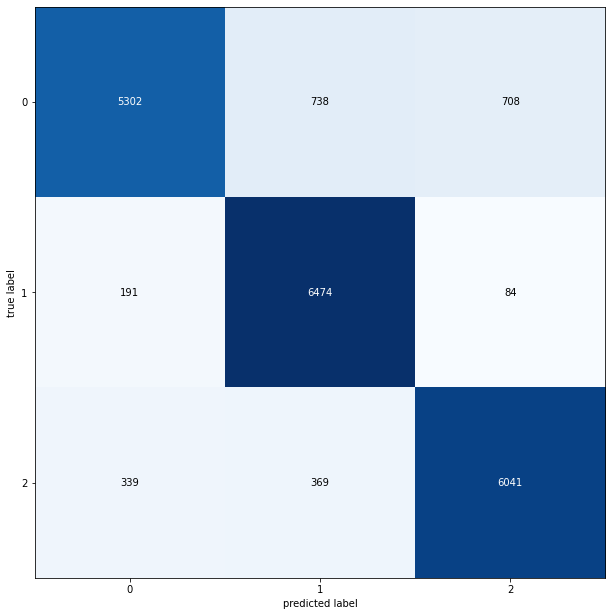

In [208]:
pretty_output(model.predict(X_TEST), Y_TEST)

In [209]:
joblib.dump(model, '_test.jlib.pack')

['_test.jlib.pack']